<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/mnist_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### PROCEDURE ###

# Step 1: Train a model on the 10-class MNIST dataset
# Step 2: Arbitrarily select a wrongly-classified test point, z_test
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z
# Step 4: Select the 500 training points with the largest |I_up,loss(z, z_test)|
# Step 5: Compute the actual change in test loss after removing the point and
#         retraining for each of the 500 points
# Step 6: Plot -1/n (I_up,loss(z, z_test)) vs. actual change in test loss for
#         each of the 500 points

In [2]:
# Step 1: Train a model on the 10-class MNIST dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# load train data: 60,000 samples
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# split train dataset into train and validation
train_size = 55000
val_size = 5000
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# load test data: 10,000 samples
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54566528.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2254945.90it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11930697.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2631288.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# create data loaders with batch size 1400
train_loader = DataLoader(dataset=train_data, batch_size=1400, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1400, shuffle=False)

In [9]:
# some functions to retrieve/view data
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_data[index]
    elif dataset == 'test':
        return test_data[index]
    elif dataset == 'val':
        return val_data[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_data[index][0].numpy().reshape(28, 28)
    elif dataset == 'test':
        img = test_data[index][0].numpy().reshape(28, 28)
    elif dataset == 'val':
        img = val_data[index][0].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [10]:
# custom module for logistic regression
class LRModel(nn.Module):
    def __init__(self):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

In [17]:
# instantiate the model
model = LRModel()

In [18]:
def train_model(model, train_loader, val_loader, epochs=1, lr=0.001):
    optimizer = optim.LBFGS(model.parameters(), lr=lr) # use LBFGS optimizer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            def closure():
              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              return loss

            loss = optimizer.step(closure)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # Validation Step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy: {100 * correct / total}%')

In [19]:
# fit the model to the train data
train_model(model, train_loader, val_loader)

Epoch 1, Loss: 1.1221379950642585
Validation Accuracy: 88.56%


In [20]:
# save the model
torch.save(model.state_dict(), 'model_weights.pth')

In [21]:
# download the weights
from google.colab import files
files.download('model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[-0.6421, -0.8940, -1.2211, -2.2992,  3.2790,  0.4088,  0.6714, -0.3081,
         -0.1881,  0.8038]], grad_fn=<AddmmBackward0>)


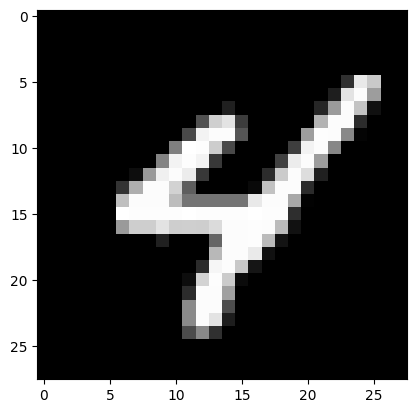

In [22]:
# check on example
image_example = get_item(4)

outputs = model(image_example[0].view(-1, 28*28))
print(outputs)

show_image(4)

In [23]:
# try to load a model from the weights
model2 = LRModel()
model2.load_state_dict(torch.load('model_weights.pth'))

<ipython-input-23-2989f722a642>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

tensor([[-0.6421, -0.8940, -1.2211, -2.2992,  3.2790,  0.4088,  0.6714, -0.3081,
         -0.1881,  0.8038]], grad_fn=<AddmmBackward0>)


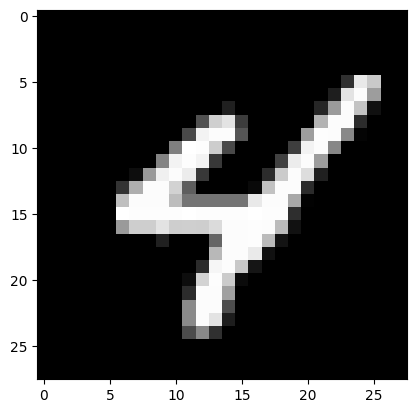

In [24]:
# check on example for new model
image_example = get_item(4)

outputs = model2(image_example[0].view(-1, 28*28))
print(outputs)

show_image(4)